In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 18.1MB/s 
     |████████████████████████████████| 194kB 43.2MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 12.8MB 42.2MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# key = os.environ.get('AZURE_SEARCH_KEY', '234b582714a64208a56aa12903a8969c')

In [ ]:
# results = search_images_bing(key, 'Normal pelvis xray', 150)
# ims = results.attrgot('content_url')
# len(ims)

150

In [ ]:
# xray_types = 'fracture femur xray ','Normal pelvis xray'
# path = Path('xrays')

In [4]:
path = Path("/content/gdrive/MyDrive/xrays")

In [ ]:
# if not path.exists():
#     path.mkdir()
#     for o in xray_types:
#         dest = (path/o)
#         dest.mkdir(exist_ok=True)
#         results = search_images_bing(key, f'{o}', 300)
#         download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)
fns

(#208) [Path('/content/gdrive/MyDrive/xrays/Normal/00000025.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000011.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000027.png'),Path('/content/gdrive/MyDrive/xrays/Normal/00000036.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000042.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000022.jpeg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000015.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000017.png'),Path('/content/gdrive/MyDrive/xrays/Normal/00000044.jpg'),Path('/content/gdrive/MyDrive/xrays/Normal/00000003.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#2) [None,None]

In [9]:
xrays = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = xrays.dataloaders(path)

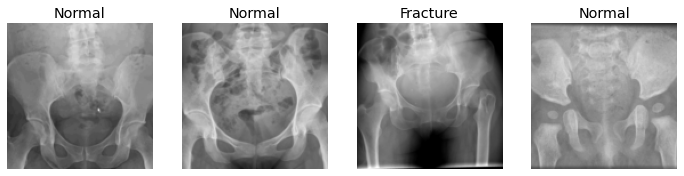

In [11]:
#These are resized to zoom to centre
dls.valid.show_batch(max_n=4, nrows=1)

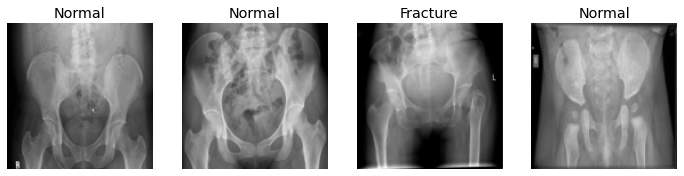

In [12]:
#These are resized to squish to include all
xrays = xrays.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = xrays.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

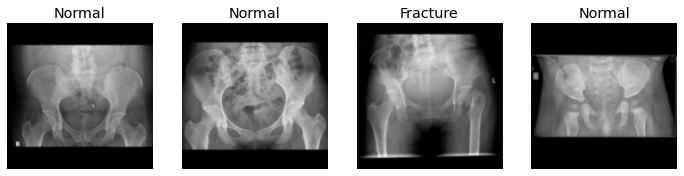

In [13]:
#These with padding
xrays = xrays.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = xrays.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

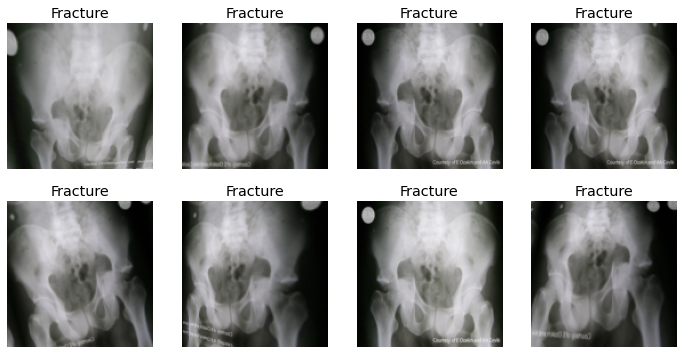

In [52]:
#Data agumentation
xrays = xrays.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'), batch_tfms=aug_transforms(mult=3.0, do_flip=True, flip_vert=False, max_rotate=5.0, 
                                                                                        min_zoom=1.0, max_zoom=1.1, max_lighting=0.1, max_warp=0.1, 
                                                                                        p_affine=0.25, p_lighting=0.25, 
                                                                                        xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', 
                                                                                        align_corners=True, batch=False, min_scale=1.0))
dls = xrays.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


#link for documentation
#https://docs.fast.ai/vision.augment.html#aug_transforms

In [53]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.241125,2.548055,0.536585,00:16


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.054732,1.962418,0.536585,00:20
1,0.991696,1.007042,0.390244,00:20
2,0.969947,0.825710,0.341463,00:20
3,0.881584,0.674545,0.292683,00:20
4,0.803359,0.567592,0.146341,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

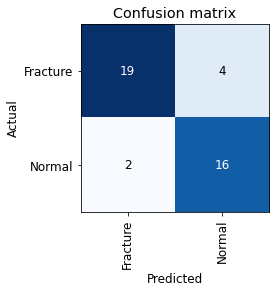

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

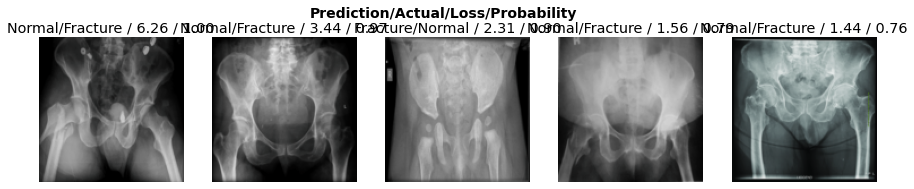

In [55]:
interp.plot_top_losses(5, nrows=1)

In [57]:
learn.export()

In [59]:
learn_inf = load_learner(path/'export.pkl')

In [60]:
#uploaded a pic from internet
learn_inf.predict('/content/normal-pelvis-and-both-hips.jpg')

('Normal', tensor(1), tensor([0.0217, 0.9783]))

In [61]:
learn_inf.dls.vocab

['Fracture', 'Normal']

In [62]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [64]:
img = PILImage.create(btn_upload.data[-1])

In [65]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [66]:
pred,pred_idx,probs = learn_inf.predict(img)

In [70]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Normal; Probability: 0.9783')

In [71]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [72]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [73]:
btn_upload = widgets.FileUpload()

In [74]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 